# 전처리 가설 검증
- df_train + 추가데이터 전부 사용  
- 5개 나라에 대해서만 진행('칠레', '중국', '노르웨이', '태국', '베트남') > ctry_list 변수에 포함되어 있음

# Setting

### Library

In [1]:
# Import Libraries
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Visuzliation Setting
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
from matplotlib import colors
import seaborn as sns

color_palette = 'Set3'
title_size = 20
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'NanumGothic'

# Modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

### Date

In [2]:
from datetime import date, timedelta


def set_week(df, date):
    '''
    df : datetime 형식의 컬럼을 가지고 있는 dataframe
    date : df에서 datetime 형식을 가진 컬럼명
    return : date의 연도 컬럼과 주차 컬럼을 추가한 dataframe
    '''
    df[date] = pd.to_datetime(df[date])
    df[date] = df[date].dt.date
    df['year'] = df.apply(func=lambda x: x[date].isocalendar()[0], axis=1)
    df['week'] = df.apply(func=lambda x: x[date].isocalendar()[1], axis=1)
    df.drop(date, axis=1, inplace=True)
    

def check_week(df):
    '''
    df에 date가 전부 있는지 확인
    '''
    cnt = 0
    sdate = date(2015, 12, 28)   # start date
    edate = date(2019, 12, 30)   # end date
    delta = edate - sdate       # as timedelta
    mem = set()
    
    for i in range(delta.days + 1):
        day = sdate + timedelta(days=i)
        year, week = day.isocalendar()[0], day.isocalendar()[1]
        if year * 100 + week in mem:
            continue
        mem.add(year * 100 + week)
        if df[(df['year'] == year) & (df['week'] == week)].empty:
            print((year, week), end="")
            cnt += 1
    if cnt > 0:
        print()
    print("missing", cnt, "values")    

### Model

In [3]:
cnt = 0
def RMSE(y, y_pred):
    return mean_squared_error(y, y_pred)**0.5


def train_model(train_data, target_data, model=LinearRegression()):  # baseline model : LInearRegression
    global cnt
    cnt += 1
    x_train, x_test, y_train, y_test = train_test_split(train_data, target_data, random_state=0)

    model.fit(x_train, y_train)
    print("Model Training Complete!")

    pred_train, pred_test = model.predict(x_train), model.predict(x_test)
    
    plt.figure(figsize=(10, 8))
#     plt.scatter(pred_train, y_train, s=10)
    sns.regplot(pred_train, y_train, color='g')
    plt.xlabel("Predicted price")
    plt.ylabel("Actual price")
    plt.savefig(os.path.join(root, 'IMAGES', str(cnt) + '.png'), transparent=True)
    plt.show()

    # cvs = cross_val_score(model, x_test, y_test, cv = 5)
    # print(">> cross_val_score mean =", cvs.mean())
    print(">> RMSE train =", RMSE(y_train, pred_train))
    print(">> RMSE validation =", RMSE(y_test, pred_test))
    print(">> MAE train =", mean_absolute_error(pred_train, y_train))
    print(">> MAE validation =", mean_absolute_error(pred_test, y_test))
    print("-------------------------------------------------")
    
    return model

    
def print_importance(model, df, added_columns):
    importance = model.coef_
    fs_data = []
    for i, x in enumerate(importance):
        fs_data.append([abs(x), df.columns[i]])
    fs_data.sort(key=lambda x: x[0], reverse=True)
   
    # 추가한 컬럼의 중요도
    for i in range(len(fs_data)):
        if fs_data[i][1] in added_columns:
            print(fs_data[i][1], ":", fs_data[i][0] ,">", i, "순위")
    print("-------------------------------------------------")
    print("총", len(fs_data) , "개")
    
    return fs_data

### Data directory

In [30]:
root = os.path.join(os.getcwd(), 'DATA')

### Merging dataframes

In [31]:
from functools import reduce

def merge_df(df_list):
    return reduce(lambda  left,right: pd.merge(left,right, on=['year', 'week'], how='left'), df_list)

# Import Data

In [52]:
df_train = pd.read_csv(os.path.join(root, 'preprocessed_train_notencoded.csv'))
df_weather_code = pd.read_csv(os.path.join(root, 'raw_weather_code.csv'), header=0, index_col=0)
weather_list = [pd.read_csv(os.path.join(root, 'raw_weather_20151228_20161227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20161228_20171227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20171228_20181227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20181228_20191227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20191228_20201227.csv'), encoding='euc-kr') , 
                pd.read_csv(os.path.join(root, 'raw_weather_20201228_20210818.csv'), encoding='euc-kr')]
df_exchange = pd.read_csv(os.path.join(root, 'preprocessed_exchange.csv'))

- 앞선 가설 검증에서 제공데이터 및 1차 추가 데이터에 대한 최적화가 완료되었기에 해당 data를 가져온다
- 제조국 날씨의 경우 결측치 처리 과정이 필요하기 때문에 raw data를 가져온다
- 수출국 환율의 경우 raw data를 가져온다

----

# Basic Dataframe
df_train
- 주요 국가 추출

### Dropping Data
날짜 데이터 및 환율 데이터는 특정 국가에 대해서만 수집할 수 있었다  
따라서 제조국이 '칠레', '중국', '노르웨이', '태국', '베트남'인 경우,  
그리고 수출국이 '칠레', '중국', '노르웨이', '태국', '베트남', '페루'인 경우만 다룬다

In [39]:
df_train = df_train[(
                    # 제조국
                    (df_train['CTRY_1'] == "칠레") |
                    (df_train['CTRY_1'] == "중국") |
                    (df_train['CTRY_1'] == "노르웨이") |
                    (df_train['CTRY_1'] == "태국") | 
                    (df_train['CTRY_1'] == "베트남")
                    ) & (
                    # 수출국
                    (df_train['CTRY_2'] == "칠레") |
                    (df_train['CTRY_2'] == "중국") | 
                    (df_train['CTRY_2'] == "노르웨이") |
                    (df_train['CTRY_2'] == "태국") | 
                    (df_train['CTRY_2'] == "베트남") |
                    (df_train['CTRY_2'] == "페루")
                    )]

----

# Baseline Dataframe
df_train
- one hot encoding

In [40]:
df0_base = df_train.copy()

### One hot encoding

In [42]:
# Others
one_hot = ['CTRY_1', 'CTRY_2', 'P_PURPOSE', 'CATEGORY_1', 'CATEGORY_2', 'P_NAME']
df0_base = pd.get_dummies(df0_base, columns=one_hot)

## Train

Model Training Complete!


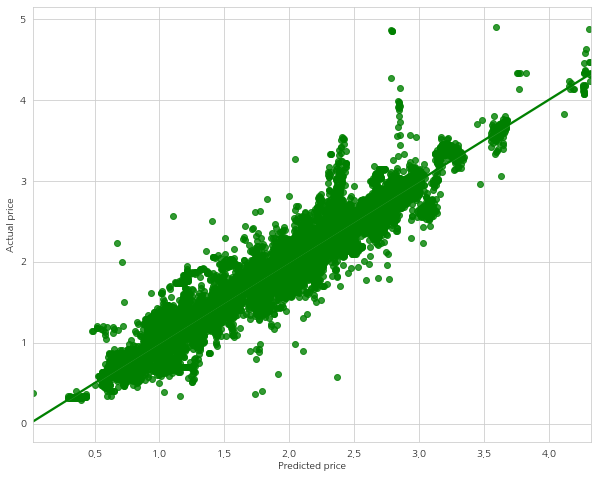

>> RMSE train = 0.20178034158408442
>> RMSE validation = 0.21534639203449177
>> MAE train = 0.13990312471904037
>> MAE validation = 0.1451043778883286
-------------------------------------------------


In [44]:
model0 = train_model(df0_base.drop(columns=['P_PRICE']), df0_base['P_PRICE'])

----
# Adding Weather Data

In [45]:
df1_with_wf = df0_base.copy()
df2_without_wf = df0_base.copy()


## Preprocess
- '지점'에 따른 나라명 컬럼(CTRY_1)과 해안가여부(is_waterfront) 추가
- 각 나라, 일자 별로 평균 강수량, 풍속, 기온 계산

In [55]:
# 지점에 따라 나라명 추가
def set_country(row):
    data = df_weather_code[df_weather_code['지점'] == row['지점']]
    if data.empty:
        return ""
    return data.iloc[0]['국가명']


def set_waterfront(row):
    data = df_weather_code[df_weather_code['지점'] == row['지점']]
    if data.empty or data.iloc[0]['해안가여부'] != 1:
        return False
    return True
    

def preprocess_weather(df, drop_waterfront):
    df = df[(df['강수량'] >= 0) & (df['풍속'] >= 0)] # 이상치/결측치 제거
    set_week(df, '일시')  # 날짜 정보 처리
    
    # 1차 평균
    columns = ['year', 'week', '지점']
    df['rain'] = df[columns + ['강수량']].groupby(columns).transform('mean')
    df['wind'] = df[columns + ['풍속']].groupby(columns).transform('mean')
    df['temperature'] = df[columns + ['기온']].groupby(columns).transform('mean')
    
    # 나라명 추가
    df['CTRY_1'] = ""
    for i, row in df.iterrows():
        df.at[i, 'CTRY_1'] = set_country(row)
    
    # 해안가 여부 추가
    df['is_waterfront'] = False
    for i, row in df.iterrows():
        df.at[i, 'is_waterfront'] = set_waterfront(row)
     
    if drop_waterfront:
        df = df[df['is_waterfront']]  # 해안가가 아닌 데이터 제외
    
    # 2차 평균
    columns = ['year', 'week', 'CTRY_1']
    df['rain'] = df[columns + ['강수량']].groupby(columns).transform('mean')
    df['wind'] = df[columns + ['풍속']].groupby(columns).transform('mean')
    df['temperature'] = df[columns + ['기온']].groupby(columns).transform('mean')

    # 컬럼/행 정리
    df.drop(columns=['지점명', '지점', '강수량', '풍속', '기온', 'is_waterfront'], inplace=True)
    df.drop_duplicates(inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df

In [ ]:
weather_with_wf = []
weather_without_wf = []
for i in range(len(weather_list)):
    weather_with_wf.append(preprocess_weather(weather_list[i], False))
    weather_without_wf.append(preprocess_weather(weather_list[i], True))

In [ ]:
df_weather_with_wf = pd.concat(weather_with_wf)
df_weather_without_wf = pd.concat(weather_without_wf)

## Check

In [351]:
for country in df_weather['CTRY_1'].unique():
    if country == "":
        continue
    print()
    print(country, "총", len(df_weather[df_weather['CTRY_1'] == country]), "개")
    check_week(df_weather[df_weather['CTRY_1'] == country])


노르웨이 총 236 개
missing 0 values

태국 총 297 개
(2016, 11)
missing 1 values

베트남 총 298 개
(2016, 6)
missing 1 values

중국 총 299 개
missing 0 values

페루 총 7 개
(2015, 53)(2016, 1)(2016, 2)(2016, 3)(2016, 4)(2016, 5)(2016, 6)(2016, 7)(2016, 8)(2016, 9)(2016, 10)(2016, 11)(2016, 12)(2016, 13)(2016, 14)(2016, 15)(2016, 16)(2016, 17)(2016, 18)(2016, 19)(2016, 20)(2016, 21)(2016, 22)(2016, 23)(2016, 24)(2016, 25)(2016, 26)(2016, 27)(2016, 28)(2016, 29)(2016, 30)(2016, 31)(2016, 32)(2016, 33)(2016, 34)(2016, 35)(2016, 36)(2016, 37)(2016, 38)(2016, 39)(2016, 40)(2016, 41)(2016, 42)(2016, 43)(2016, 44)(2016, 45)(2016, 46)(2016, 47)(2016, 48)(2016, 49)(2016, 51)(2016, 52)(2017, 1)(2017, 2)(2017, 3)(2017, 4)(2017, 5)(2017, 6)(2017, 7)(2017, 8)(2017, 9)(2017, 10)(2017, 12)(2017, 13)(2017, 14)(2017, 15)(2017, 16)(2017, 17)(2017, 18)(2017, 19)(2017, 20)(2017, 21)(2017, 22)(2017, 23)(2017, 24)(2017, 25)(2017, 26)(2017, 27)(2017, 28)(2017, 29)(2017, 30)(2017, 31)(2017, 32)(2017, 33)(2017, 34)(2017, 35)(2017, 3

## Filling Missing Values

- 노르웨이, 중국은 결측치 없음
- 태국, 베트남, 칠레는 결측치 1개
> 전/차주 데이터 평균으로 채워넣기
- 페루는 결측치 299개
> 사용 불가

In [352]:
def get_avg(year, week, country, value):
  return (df_weather[(df_weather['year'] == year) & (df_weather['week'] == week + 1) & (df_weather['CTRY_1'] == country)].iloc[0][value] 
          + df_weather[(df_weather['year'] == year) & (df_weather['week'] == week - 1) & (df_weather['CTRY_1'] == country)].iloc[0][value]) / 2

In [353]:
df_weather = df_weather.append({'year': 2016,
                                'week': 11,
                                'CTRY_1': '태국',
                                'rain': get_avg(2016, 11, '태국', 'rain'),
                                'wind': get_avg(2016, 11, '태국', 'wind'),
                                'temperature': get_avg(2016, 11, '태국', 'temperature')},
                               ignore_index=True)
df_weather = df_weather.append({'year': 2016,
                                'week': 6,
                                'CTRY_1': '베트남',
                                'rain': get_avg(2016, 6, '베트남', 'rain'),
                                'wind': get_avg(2016, 6, '베트남', 'wind'),
                                'temperature': get_avg(2016, 6, '베트남', 'temperature')},
                               ignore_index=True)
df_weather = df_weather.append({'year': 2016,
                                'week': 5,
                                'CTRY_1': '칠레',
                                'rain': get_avg(2016, 5, '칠레', 'rain'),
                                'wind': get_avg(2016, 5, '칠레', 'wind'),
                                'temperature': get_avg(2016, 5, '칠레', 'temperature')},
                               ignore_index=True)

for country in ["태국", "베트남", "칠레"]:
    print()
    print(country, "총", len(df_weather[df_weather['CTRY_1'] == country]), "개")
    check_week(df_weather[df_weather['CTRY_1'] == country])


태국 총 298 개
missing 0 values

베트남 총 299 개
missing 0 values

칠레 총 298 개
missing 0 values


## Add to Training Data

In [354]:
df_train = pd.merge(df_train, df_weather, how='left', on=['year', 'week', 'CTRY_1'])

In [ ]:
df8_add = pd.merge(df6_category, df_weather_kr, how='left', on=['year', 'week'])
df8_add = pd.merge(df8_add, df_weather, how='left', on=['year', 'week', 'CTRY_1'])
df8_add = pd.merge(df8_add, df_oil, how='left', on=['year', 'week'])
df8_add = pd.merge(df8_add, df_cpi, how='left', on=['year', 'week'])
df8_add = pd.merge(df8_add, df_exchange, how='left', on=['year', 'week', 'CTRY_2'])

In [ ]:
df8_add

,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,P_NAME,P_PRICE,껍질,한쪽껍질붙은,냉장,절단,목살,개아지살,포장횟감,캐비아대용,자숙,슬라이스(S),곤이,다리,횟감,필렛(F),지느러미,난포선,동체,염장,볼살,간,건조,줄기,활,알,냉동,살,year,week,name_cnt,wind_kr,temperature_kr,water_temp_kr,rain,wind,temperature,oil,cpi_total,cpi_fish,exchange
0,칠레,칠레,판매용,패류 멍게류,해삼,18.260870,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2015,53,13,5.352941,7.973109,13.732174,0.580000,6.833333,16.963333,37.08,100.22,101.26,0.0014
1,칠레,칠레,판매용,패류 멍게류,해삼,18.260870,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2015,53,13,5.352941,7.973109,13.732174,0.580000,6.833333,16.963333,37.08,100.39,100.76,0.0014
2,중국,중국,판매용,어류,서대,4.791340,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2015,53,74,5.352941,7.973109,13.732174,1.101826,2.242009,6.697717,37.08,100.22,101.26,0.1541
3,중국,중국,판매용,어류,서대,4.791340,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2015,53,74,5.352941,7.973109,13.732174,1.101826,2.242009,6.697717,37.08,100.39,100.76,0.1541
4,중국,중국,판매용,어류,은밀복,2.167951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2015,53,117,5.352941,7.973109,13.732174,1.101826,2.242009,6.697717,37.08,100.22,101.26,0.1541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25289,중국,중국,판매용,연체류 해물모듬,낙지,8.282274,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2020,1,1342,6.534266,6.942657,13.188652,2.045970,2.498507,5.346567,61.66,105.79,118.44,0.1431
25290,중국,중국,판매용,패류 멍게류,바지락,0.852967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2020,1,601,6.534266,6.942657,13.188652,2.045970,2.498507,5.346567,61.66,105.12,116.99,0.1431
25291,중국,중국,판매용,패류 멍게류,바지락,0.852967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2020,1,601,6.534266,6.942657,13.188652,2.045970,2.498507,5.346567,61.66,105.79,118.44,0.1431
25292,노르웨이,노르웨이,판매용,어류,연어,13.205675,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,1282,6.534266,6.942657,13.188652,3.050417,7.291667,0.154701,61.66,105.12,116.99,0.1134


----
# Adding Exchange Data

In [ ]:
df3_add_exchange = 

----
# Scaling & Normalization

In [ ]:
df4_transform = 

# df9_add

In [ ]:
df9_add = df8_add.copy()

In [ ]:
columns = ['wind_kr','temperature_kr','water_temp_kr','oil','cpi_total','cpi_fish','exchange']

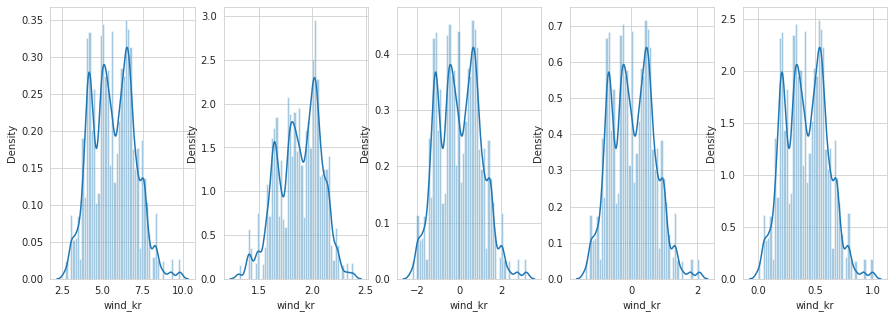

In [ ]:
for i in columns:

  if i == 'wind_kr':
    f, ax = plt.subplots(figsize = (15, 5)) 
    plt.subplot(151)
    sns.distplot(df9_add[i])
    
    df_copy = df9_add.copy()
    df_copy[columns] = np.log1p(df_copy[columns])
    plt.subplot(152)
    sns.distplot(df_copy[i])

    df_copy1 = df9_add.copy()
    scaler = StandardScaler()
    df_copy1[columns] = scaler.fit_transform(df_copy1[columns])
    plt.subplot(153)
    sns.distplot(df_copy1[i])
    
    df_copy2 = df9_add.copy()
    scaler = RobustScaler()
    df_copy2[columns] = scaler.fit_transform(df_copy2[columns])
    plt.subplot(154)
    sns.distplot(df_copy2[i])
    
    df_copy3 = df9_add.copy()
    scaler = MinMaxScaler()
    df_copy3[columns] = scaler.fit_transform(df_copy3[columns])
    plt.subplot(155)
    sns.distplot(df_copy3[i])

findfont: Font family ['NanumGothic'] not found. Falling back to DejaVu Sans.


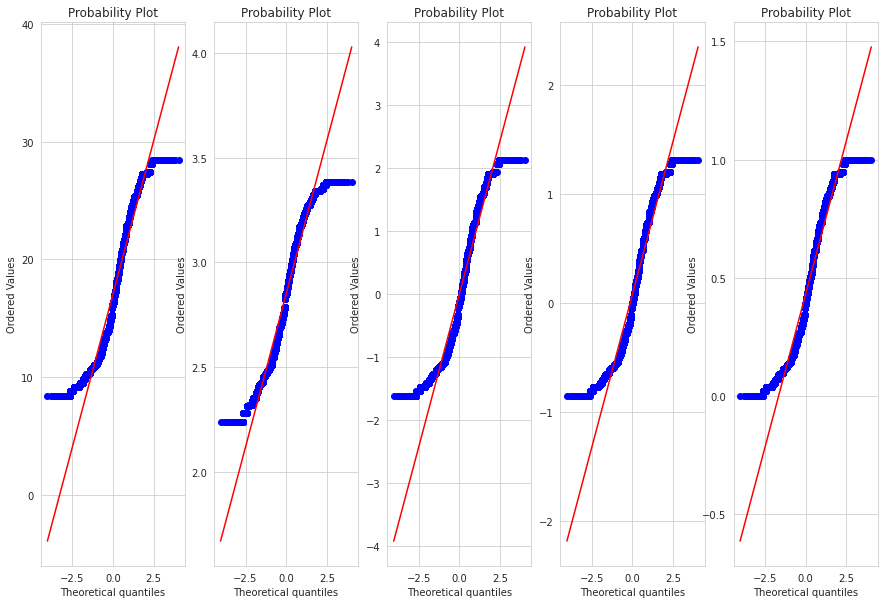

In [ ]:
from scipy import stats 

fig = plt.figure(figsize = (15,10))

for i in columns:

  if i == 'water_temp_kr':
    fig.add_subplot(151) 
    res = stats.probplot(df9_add[i], plot=plt) 
    
    fig.add_subplot(152) 
    res = stats.probplot(df_copy[i], plot=plt)
    
    fig.add_subplot(153) 
    res = stats.probplot(df_copy1[i], plot=plt)
    
    fig.add_subplot(154) 
    res = stats.probplot(df_copy2[i], plot=plt)
    
    fig.add_subplot(155) 
    res = stats.probplot(df_copy3[i], plot=plt)

oil를 제외한 모든 추가 변수는 로그 변환

oil은 표준화

날씨 데이터는 이상치 처리 후 정규화 예정



In [ ]:
df9_add['wind_kr'] = np.log1p(df9_add['wind_kr'])
df9_add['water_temp_kr'] = np.log1p(df9_add['water_temp_kr'])
df9_add['oil'] = np.log1p(df9_add['oil'])
df9_add['cpi_total'] = np.log1p(df9_add['cpi_total'])
df9_add['cpi_fish'] = np.log1p(df9_add['cpi_fish'])
df9_add['exchange'] = np.log1p(df9_add['exchange'])

df9_add['temperature_kr'] = (df9_add['temperature_kr'] - df9_add['temperature_kr'].mean())/df9_add['temperature_kr'].std()
df9_add['oil'] = (df9_add['oil'] - df9_add['oil'].mean())/df9_add['oil'].std()

df9_add


,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,P_NAME,P_PRICE,껍질,한쪽껍질붙은,냉장,절단,목살,개아지살,포장횟감,캐비아대용,자숙,슬라이스(S),곤이,다리,횟감,필렛(F),지느러미,난포선,동체,염장,볼살,간,건조,줄기,활,알,냉동,살,year,week,name_cnt,wind_kr,temperature_kr,water_temp_kr,rain,wind,temperature,oil,cpi_total,cpi_fish,exchange
0,칠레,칠레,판매용,패류 멍게류,해삼,18.260870,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2015,53,13,1.848918,-0.928353,2.690034,0.580000,6.833333,16.963333,-1.987367,4.617296,4.627519,0.001399
1,칠레,칠레,판매용,패류 멍게류,해삼,18.260870,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,2015,53,13,1.848918,-0.928353,2.690034,0.580000,6.833333,16.963333,-1.987367,4.618974,4.622617,0.001399
2,중국,중국,판매용,어류,서대,4.791340,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2015,53,74,1.848918,-0.928353,2.690034,1.101826,2.242009,6.697717,-1.987367,4.617296,4.627519,0.143321
3,중국,중국,판매용,어류,서대,4.791340,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2015,53,74,1.848918,-0.928353,2.690034,1.101826,2.242009,6.697717,-1.987367,4.618974,4.622617,0.143321
4,중국,중국,판매용,어류,은밀복,2.167951,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2015,53,117,1.848918,-0.928353,2.690034,1.101826,2.242009,6.697717,-1.987367,4.617296,4.627519,0.143321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25289,중국,중국,판매용,연체류 해물모듬,낙지,8.282274,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2020,1,1342,2.019461,-1.068801,2.652443,2.045970,2.498507,5.346567,0.807966,4.670864,4.782814,0.133744
25290,중국,중국,판매용,패류 멍게류,바지락,0.852967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2020,1,601,2.019461,-1.068801,2.652443,2.045970,2.498507,5.346567,0.807966,4.664571,4.770600,0.133744
25291,중국,중국,판매용,패류 멍게류,바지락,0.852967,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2020,1,601,2.019461,-1.068801,2.652443,2.045970,2.498507,5.346567,0.807966,4.670864,4.782814,0.133744
25292,노르웨이,노르웨이,판매용,어류,연어,13.205675,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,1282,2.019461,-1.068801,2.652443,3.050417,7.291667,0.154701,0.807966,4.664571,4.770600,0.107418


# df10_fillna 

In [ ]:
df10_fillna = df9_add.copy()

df10_fillna = df10_fillna.sort_values('CTRY_1')

df10_fillna.isna().sum()

CTRY_1               0
CTRY_2               0
P_PURPOSE            0
CATEGORY_1           0
P_NAME               0
P_PRICE              0
껍질                   0
한쪽껍질붙은               0
냉장                   0
절단                   0
목살                   0
개아지살                 0
포장횟감                 0
캐비아대용                0
자숙                   0
슬라이스(S)              0
곤이                   0
다리                   0
횟감                   0
필렛(F)                0
지느러미                 0
난포선                  0
동체                   0
염장                   0
볼살                   0
간                    0
건조                   0
줄기                   0
활                    0
알                    0
냉동                   0
살                    0
year                 0
week                 0
name_cnt             0
wind_kr              0
temperature_kr       0
water_temp_kr        0
rain              1184
wind              1184
temperature       1184
oil                  0
cpi_total            0
cpi_fish   

페루 날씨 데이터만 결측치 존재 -> 가까운 페루 데이터로 대치

In [ ]:
df10_fillna.fillna(method='ffill',inplace=True)

df10_fillna.isna().sum()

CTRY_1            0
CTRY_2            0
P_PURPOSE         0
CATEGORY_1        0
P_NAME            0
P_PRICE           0
껍질                0
한쪽껍질붙은            0
냉장                0
절단                0
목살                0
개아지살              0
포장횟감              0
캐비아대용             0
자숙                0
슬라이스(S)           0
곤이                0
다리                0
횟감                0
필렛(F)             0
지느러미              0
난포선               0
동체                0
염장                0
볼살                0
간                 0
건조                0
줄기                0
활                 0
알                 0
냉동                0
살                 0
year              0
week              0
name_cnt          0
wind_kr           0
temperature_kr    0
water_temp_kr     0
rain              0
wind              0
temperature       0
oil               0
cpi_total         0
cpi_fish          0
exchange          0
dtype: int64

In [ ]:
df10_fillna

,CTRY_1,CTRY_2,P_PURPOSE,CATEGORY_1,P_NAME,P_PRICE,껍질,한쪽껍질붙은,냉장,절단,목살,개아지살,포장횟감,캐비아대용,자숙,슬라이스(S),곤이,다리,횟감,필렛(F),지느러미,난포선,동체,염장,볼살,간,건조,줄기,활,알,냉동,살,year,week,name_cnt,wind_kr,temperature_kr,water_temp_kr,rain,wind,temperature,oil,cpi_total,cpi_fish,exchange
25293,노르웨이,노르웨이,판매용,어류,연어,13.205675,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,1282,2.019461,-1.068801,2.652443,3.050417,7.291667,0.154701,0.807966,4.670864,4.782814,0.107418
20198,노르웨이,노르웨이,판매용,어류,연어,10.488739,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,10,1282,1.894744,-0.739994,2.485824,1.959933,5.013468,-2.686532,0.317802,4.658616,4.723131,0.109392
20187,노르웨이,노르웨이,자사제품제조용,어류,연어,15.382828,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2019,10,1282,1.894744,-0.739994,2.485824,1.959933,5.013468,-2.686532,0.317802,4.658616,4.723131,0.109392
20179,노르웨이,노르웨이,판매용,어류,고등어,2.221174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2019,10,264,1.894744,-0.739994,2.485824,1.959933,5.013468,-2.686532,0.317802,4.658616,4.723131,0.109392
5654,노르웨이,노르웨이,자사제품제조용,어류,연어,10.570434,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016,48,1282,1.999789,-0.499633,2.843599,2.235857,6.681275,0.863745,-0.470291,4.629375,4.656148,0.110736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20965,페루,페루,판매용,갑각류,흰다리새우,8.399954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2019,18,1964,1.626871,-0.028444,2.733181,0.100000,4.000000,25.600000,0.922519,4.663911,4.737338,0.263287
20966,페루,페루,판매용,알 곤이류,성게알,67.278261,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,18,75,1.626871,-0.028444,2.733181,0.100000,4.000000,25.600000,0.922519,4.662212,4.731803,0.263287
20967,페루,페루,판매용,알 곤이류,성게알,67.278261,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,18,75,1.626871,-0.028444,2.733181,0.100000,4.000000,25.600000,0.922519,4.663911,4.737338,0.263287
4764,페루,페루,판매용,어류,붕장어,5.642371,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016,41,110,1.822786,0.656476,3.108498,0.100000,4.000000,25.600000,-0.279644,4.630838,4.637056,0.258202


## Encoding

In [ ]:
df10_fillna_encoding = pd.get_dummies(df10_fillna,columns=['CTRY_1','CTRY_2','CATEGORY_1','P_PURPOSE','P_NAME'])

df10_fillna_encoding

,P_PRICE,껍질,한쪽껍질붙은,냉장,절단,목살,개아지살,포장횟감,캐비아대용,자숙,슬라이스(S),곤이,다리,횟감,필렛(F),지느러미,난포선,동체,염장,볼살,간,건조,줄기,활,알,냉동,살,year,week,name_cnt,wind_kr,temperature_kr,water_temp_kr,rain,wind,temperature,oil,cpi_total,cpi_fish,exchange,...,"P_NAME_전갱이,POMPANO",P_NAME_젓새우,P_NAME_조피볼락,P_NAME_주꾸미,P_NAME_주름백합,P_NAME_쥐노래미,P_NAME_쥐치,P_NAME_진홍퉁돔,P_NAME_참게,P_NAME_참돔,P_NAME_참복,P_NAME_참조기,P_NAME_청각,P_NAME_청새치,P_NAME_청어알,P_NAME_칠성장어,P_NAME_코드아이스피쉬,P_NAME_큰구슬우렁이,P_NAME_큰민어,P_NAME_키조개,P_NAME_톱날꽃게,P_NAME_틸라피아,P_NAME_파타고니아이빨고기,P_NAME_피뿔고둥,P_NAME_피조개,P_NAME_학공치,P_NAME_해물혼합,P_NAME_해삼,P_NAME_해파리,P_NAME_홍다리얼룩새우,P_NAME_홍민어,P_NAME_홍어,P_NAME_홍합,P_NAME_화살오징어,P_NAME_황다랑어,P_NAME_황새치,P_NAME_황적퉁돔,P_NAME_흑기흉상어,P_NAME_흑밀복,P_NAME_흰다리새우
25293,13.205675,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,1282,2.019461,-1.068801,2.652443,3.050417,7.291667,0.154701,0.807966,4.670864,4.782814,0.107418,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20198,10.488739,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,10,1282,1.894744,-0.739994,2.485824,1.959933,5.013468,-2.686532,0.317802,4.658616,4.723131,0.109392,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20187,15.382828,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2019,10,1282,1.894744,-0.739994,2.485824,1.959933,5.013468,-2.686532,0.317802,4.658616,4.723131,0.109392,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20179,2.221174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2019,10,264,1.894744,-0.739994,2.485824,1.959933,5.013468,-2.686532,0.317802,4.658616,4.723131,0.109392,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5654,10.570434,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016,48,1282,1.999789,-0.499633,2.843599,2.235857,6.681275,0.863745,-0.470291,4.629375,4.656148,0.110736,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20965,8.399954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2019,18,1964,1.626871,-0.028444,2.733181,0.100000,4.000000,25.600000,0.922519,4.663911,4.737338,0.263287,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20966,67.278261,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,18,75,1.626871,-0.028444,2.733181,0.100000,4.000000,25.600000,0.922519,4.662212,4.731803,0.263287,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20967,67.278261,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,18,75,1.626871,-0.028444,2.733181,0.100000,4.000000,25.600000,0.922519,4.663911,4.737338,0.263287,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4764,5.642371,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016,41,110,1.822786,0.656476,3.108498,0.100000,4.000000,25.600000,-0.279644,4.630838,4.637056,0.258202,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## result

Model Training Complete!


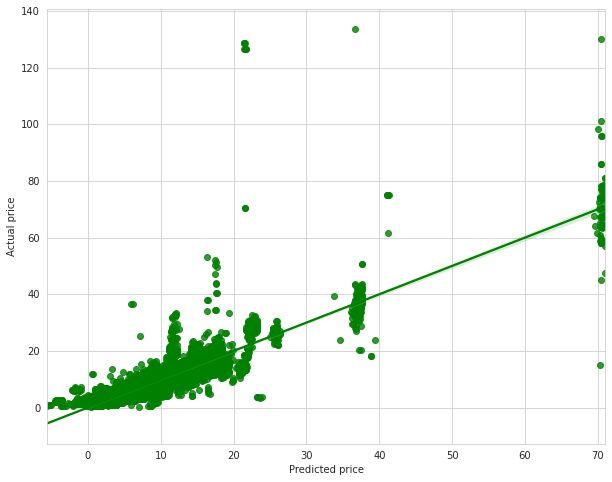

>> RMSE train = 3.411088402491785
>> RMSE validation = 7988.043411372703
>> MAE train = 1.5340775921457224
>> MAE validation = 231.367512039203
-------------------------------------------------


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
x_features = df10_fillna_encoding.iloc[:,1:]
y_target = df10_fillna_encoding['P_PRICE']

train_model(x_features,y_target)

# 추가 데이터 스케일링, 결측치 처리 완료 모델

# df11_outlier

In [ ]:
df12_outlier = df10_fillna.copy()

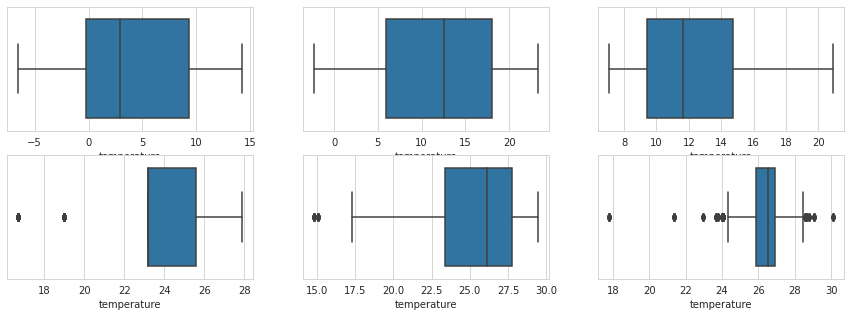

In [ ]:
plt.figure(figsize=(15,5))

plt.subplot(231)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='노르웨이']['temperature'])

plt.subplot(232)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='중국']['temperature'])

plt.subplot(233)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='칠레']['temperature'])

plt.subplot(234)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='페루']['temperature'])

plt.subplot(235)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='베트남']['temperature'])

plt.subplot(236)
sns.boxplot(df12_outlier[df12_outlier['CTRY_1']=='태국']['temperature'])

plt.show()

# 각 나라 최저,최고기온 비교 후 이상치 여부 판단
# 이상치 존재 x

In [ ]:
df12_outlier['temperature'] = (df12_outlier['temperature'] - df12_outlier['temperature'].mean())/df12_outlier['temperature'].std()
df12_outlier['rain'] = (df12_outlier['rain'] - df12_outlier['rain'].mean())/df12_outlier['rain'].std()
df12_outlier['wind'] = (df12_outlier['wind'] - df12_outlier['wind'].mean())/df12_outlier['wind'].std()

## Encoding

In [ ]:
df12_outlier_encoding = pd.get_dummies(df12_outlier,columns=['CTRY_1','CTRY_2','CATEGORY_1','P_PURPOSE','P_NAME'])

df12_outlier_encoding

,P_PRICE,껍질,한쪽껍질붙은,냉장,절단,목살,개아지살,포장횟감,캐비아대용,자숙,슬라이스(S),곤이,다리,횟감,필렛(F),지느러미,난포선,동체,염장,볼살,간,건조,줄기,활,알,냉동,살,year,week,name_cnt,wind_kr,temperature_kr,water_temp_kr,rain,wind,temperature,oil,cpi_total,cpi_fish,exchange,...,"P_NAME_전갱이,POMPANO",P_NAME_젓새우,P_NAME_조피볼락,P_NAME_주꾸미,P_NAME_주름백합,P_NAME_쥐노래미,P_NAME_쥐치,P_NAME_진홍퉁돔,P_NAME_참게,P_NAME_참돔,P_NAME_참복,P_NAME_참조기,P_NAME_청각,P_NAME_청새치,P_NAME_청어알,P_NAME_칠성장어,P_NAME_코드아이스피쉬,P_NAME_큰구슬우렁이,P_NAME_큰민어,P_NAME_키조개,P_NAME_톱날꽃게,P_NAME_틸라피아,P_NAME_파타고니아이빨고기,P_NAME_피뿔고둥,P_NAME_피조개,P_NAME_학공치,P_NAME_해물혼합,P_NAME_해삼,P_NAME_해파리,P_NAME_홍다리얼룩새우,P_NAME_홍민어,P_NAME_홍어,P_NAME_홍합,P_NAME_화살오징어,P_NAME_황다랑어,P_NAME_황새치,P_NAME_황적퉁돔,P_NAME_흑기흉상어,P_NAME_흑밀복,P_NAME_흰다리새우
25293,13.205675,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020,1,1282,2.019461,-1.068801,2.652443,-0.161223,0.288622,-1.720837,0.807966,4.670864,4.782814,0.107418,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20198,10.488739,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,10,1282,1.894744,-0.739994,2.485824,-0.177855,0.052206,-2.031843,0.317802,4.658616,4.723131,0.109392,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20187,15.382828,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,2019,10,1282,1.894744,-0.739994,2.485824,-0.177855,0.052206,-2.031843,0.317802,4.658616,4.723131,0.109392,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20179,2.221174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2019,10,264,1.894744,-0.739994,2.485824,-0.177855,0.052206,-2.031843,0.317802,4.658616,4.723131,0.109392,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5654,10.570434,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2016,48,1282,1.999789,-0.499633,2.843599,-0.173646,0.225280,-1.643224,-0.470291,4.629375,4.656148,0.110736,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20965,8.399954,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2019,18,1964,1.626871,-0.028444,2.733181,-0.206221,-0.052964,1.064446,0.922519,4.663911,4.737338,0.263287,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
20966,67.278261,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,18,75,1.626871,-0.028444,2.733181,-0.206221,-0.052964,1.064446,0.922519,4.662212,4.731803,0.263287,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20967,67.278261,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2019,18,75,1.626871,-0.028444,2.733181,-0.206221,-0.052964,1.064446,0.922519,4.663911,4.737338,0.263287,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4764,5.642371,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2016,41,110,1.822786,0.656476,3.108498,-0.206221,-0.052964,1.064446,-0.279644,4.630838,4.637056,0.258202,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Result

Model Training Complete!


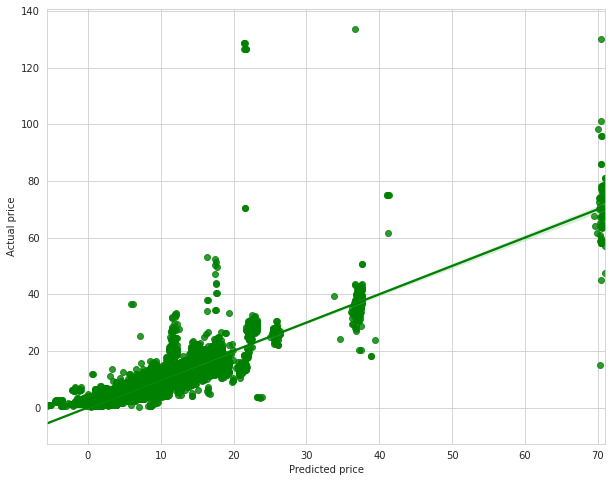

>> RMSE train = 3.4110879311964317
>> RMSE validation = 1084.7292695155943
>> MAE train = 1.5340305516708403
>> MAE validation = 32.580724460811055
-------------------------------------------------


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
x_features = df12_outlier_encoding.iloc[:,1:]
y_target = df12_outlier_encoding['P_PRICE']

train_model(x_features,y_target)

# 날씨 데이터 스케일링 완료 모델

# Final

위 결과들을 토대로 최종 결과 도출.

## Preprocessing

In [ ]:
# df1_date
# df6_category

df_add = pd.merge(df0_base[['P_PRICE','year','week','CTRY_1','CTRY_2','CATEGORY_1','CATEGORY_2','P_PURPOSE','P_NAME']],df_oil,on=['year','week'])
df_add = pd.merge(df_add,df_weather,on=['year','week','CTRY_1'])
df_add = pd.merge(df_add,df_weather_kr,on=['year','week'])
df_add = pd.merge(df_add,df_exchange,on=['year','week','CTRY_2'])
df_add = pd.merge(df_add,df_cpi,on=['year','week'])

df_add

,P_PRICE,year,week,CTRY_1,CTRY_2,CATEGORY_1,CATEGORY_2,P_PURPOSE,P_NAME,oil,rain,wind,temperature,wind_kr,temperature_kr,water_temp_kr,exchange,cpi_total,cpi_fish
0,18.260870,2015,53,칠레,칠레,패류 멍게류,해삼,판매용,해삼,37.08,0.580,6.833333,16.963333,5.352941,7.973109,13.732174,0.0014,100.22,101.26
1,18.260870,2015,53,칠레,칠레,패류 멍게류,해삼,판매용,해삼,37.08,0.580,6.833333,16.963333,5.352941,7.973109,13.732174,0.0014,100.39,100.76
2,4.800021,2015,53,칠레,칠레,어류,연어,판매용,대서양연어,37.08,0.580,6.833333,16.963333,5.352941,7.973109,13.732174,0.0014,100.22,101.26
3,4.800021,2015,53,칠레,칠레,어류,연어,판매용,대서양연어,37.08,0.580,6.833333,16.963333,5.352941,7.973109,13.732174,0.0014,100.39,100.76
4,0.968083,2015,53,칠레,칠레,연체류 해물모듬,오징어,판매용,오징어,37.08,0.580,6.833333,16.963333,5.352941,7.973109,13.732174,0.0014,100.22,101.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24105,9.800319,2020,1,태국,태국,연체류 해물모듬,낙지,판매용,낙지,61.66,0.075,3.000000,28.600000,6.534266,6.942657,13.188652,0.0334,105.79,118.44
24106,6.852682,2020,1,태국,태국,연체류 해물모듬,쭈꾸미,판매용,주꾸미,61.66,0.075,3.000000,28.600000,6.534266,6.942657,13.188652,0.0334,105.12,116.99
24107,6.852682,2020,1,태국,태국,연체류 해물모듬,쭈꾸미,판매용,주꾸미,61.66,0.075,3.000000,28.600000,6.534266,6.942657,13.188652,0.0334,105.79,118.44
24108,7.060727,2020,1,태국,태국,연체류 해물모듬,쭈꾸미,판매용,주꾸미,61.66,0.075,3.000000,28.600000,6.534266,6.942657,13.188652,0.0334,105.12,116.99


In [ ]:
# df4_name
# 어종별 수 컬럼 추가

df_add['name_cnt'] = 0;
value_dict = {}
for name, value in zip(df_add['P_NAME'].value_counts().index,df_add['P_NAME'].value_counts()):
    value_dict[name] = value

def value(col):
    return value_dict[col]

df_add['name_cnt'] = df_add['P_NAME'].apply(value)

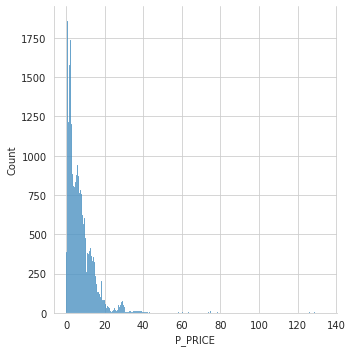

In [ ]:
sns.displot(df_add['P_PRICE']) # 왜도가 매우 심함 -> 스케일링 필요

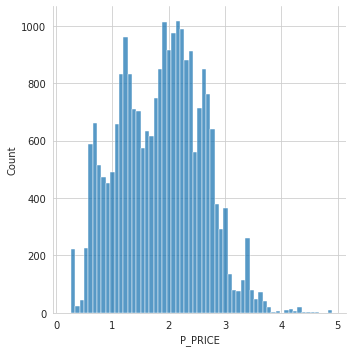

In [ ]:
sns.displot(np.log1p(df_add['P_PRICE'])) # 정규분포에 가까운 형태로 변환.

In [ ]:
# df9_add

df_add['P_PRICE'] = np.log1p(df_add['P_PRICE'])
df_add['wind_kr'] = np.log1p(df_add['wind_kr'])
df_add['water_temp_kr'] = np.log1p(df_add['water_temp_kr'])
df_add['oil'] = np.log1p(df_add['oil'])
df_add['cpi_total'] = np.log1p(df_add['cpi_total'])
df_add['cpi_fish'] = np.log1p(df_add['cpi_fish'])
df_add['exchange'] = np.log1p(df_add['exchange'])

df_add['temperature_kr'] = (df_add['temperature_kr'] - df_add['temperature_kr'].mean())/df_add['temperature_kr'].std()
df_add['oil'] = (df_add['oil'] - df_add['oil'].mean())/df_add['oil'].std()
df_add['rain'] = (df_add['rain'] - df_add['rain'].mean())/df_add['rain'].std()
df_add['wind'] = (df_add['wind'] - df_add['wind'].mean())/df_add['wind'].std()
df_add['temperature'] = (df_add['temperature'] - df_add['temperature'].mean())/df_add['temperature'].std()


df_add


,P_PRICE,year,week,CTRY_1,CTRY_2,CATEGORY_1,CATEGORY_2,P_PURPOSE,P_NAME,oil,rain,wind,temperature,wind_kr,temperature_kr,water_temp_kr,exchange,cpi_total,cpi_fish,name_cnt
0,2.958076,2015,53,칠레,칠레,패류 멍게류,해삼,판매용,해삼,-1.980385,-0.286460,1.984186,0.162760,1.848918,-0.919488,2.690034,0.001399,4.617296,4.627519,16
1,2.958076,2015,53,칠레,칠레,패류 멍게류,해삼,판매용,해삼,-1.980385,-0.286460,1.984186,0.162760,1.848918,-0.919488,2.690034,0.001399,4.618974,4.622617,16
2,1.757862,2015,53,칠레,칠레,어류,연어,판매용,대서양연어,-1.980385,-0.286460,1.984186,0.162760,1.848918,-0.919488,2.690034,0.001399,4.617296,4.627519,326
3,1.757862,2015,53,칠레,칠레,어류,연어,판매용,대서양연어,-1.980385,-0.286460,1.984186,0.162760,1.848918,-0.919488,2.690034,0.001399,4.618974,4.622617,326
4,0.677060,2015,53,칠레,칠레,연체류 해물모듬,오징어,판매용,오징어,-1.980385,-0.286460,1.984186,0.162760,1.848918,-0.919488,2.690034,0.001399,4.617296,4.627519,1330
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24105,2.379576,2020,1,태국,태국,연체류 해물모듬,낙지,판매용,낙지,0.814296,-0.321298,0.057184,1.434923,2.019461,-1.060140,2.652443,0.032854,4.670864,4.782814,1647
24106,2.060855,2020,1,태국,태국,연체류 해물모듬,쭈꾸미,판매용,주꾸미,0.814296,-0.321298,0.057184,1.434923,2.019461,-1.060140,2.652443,0.032854,4.664571,4.770600,1182
24107,2.060855,2020,1,태국,태국,연체류 해물모듬,쭈꾸미,판매용,주꾸미,0.814296,-0.321298,0.057184,1.434923,2.019461,-1.060140,2.652443,0.032854,4.670864,4.782814,1182
24108,2.087004,2020,1,태국,태국,연체류 해물모듬,쭈꾸미,판매용,주꾸미,0.814296,-0.321298,0.057184,1.434923,2.019461,-1.060140,2.652443,0.032854,4.664571,4.770600,1182


## Encoding

In [ ]:
# Categorical Features Encoding

df_add_encoding = pd.get_dummies(df_add,columns=['CTRY_1','CTRY_2','CATEGORY_1','CATEGORY_2','P_PURPOSE','P_NAME'])

df_add_encoding

,P_PRICE,year,week,oil,rain,wind,temperature,wind_kr,temperature_kr,water_temp_kr,exchange,cpi_total,cpi_fish,name_cnt,CTRY_1_노르웨이,CTRY_1_베트남,CTRY_1_중국,CTRY_1_칠레,CTRY_1_태국,CTRY_1_페루,CTRY_2_노르웨이,CTRY_2_베트남,CTRY_2_중국,CTRY_2_칠레,CTRY_2_태국,CTRY_2_페루,CATEGORY_1_갑각류,CATEGORY_1_기타 수입식품,CATEGORY_1_알 곤이류,CATEGORY_1_어류,CATEGORY_1_연체류 해물모듬,CATEGORY_1_젓갈류 해조류 해파리,CATEGORY_1_패류 멍게류,CATEGORY_2_가리비,CATEGORY_2_가사리,CATEGORY_2_가오리,CATEGORY_2_가자미,CATEGORY_2_가재 랍스타,CATEGORY_2_갈치,CATEGORY_2_갑오징어,...,"P_NAME_전갱이,POMPANO",P_NAME_젓새우,P_NAME_조피볼락,P_NAME_주꾸미,P_NAME_주름백합,P_NAME_쥐노래미,P_NAME_쥐치,P_NAME_진홍퉁돔,P_NAME_참게,P_NAME_참돔,P_NAME_참복,P_NAME_참조기,P_NAME_청각,P_NAME_청새치,P_NAME_청어알,P_NAME_칠성장어,P_NAME_코드아이스피쉬,P_NAME_큰구슬우렁이,P_NAME_큰민어,P_NAME_키조개,P_NAME_톱날꽃게,P_NAME_틸라피아,P_NAME_파타고니아이빨고기,P_NAME_피뿔고둥,P_NAME_피조개,P_NAME_학공치,P_NAME_해물혼합,P_NAME_해삼,P_NAME_해파리,P_NAME_홍다리얼룩새우,P_NAME_홍민어,P_NAME_홍어,P_NAME_홍합,P_NAME_화살오징어,P_NAME_황다랑어,P_NAME_황새치,P_NAME_황적퉁돔,P_NAME_흑기흉상어,P_NAME_흑밀복,P_NAME_흰다리새우
0,2.958076,2015,53,-1.980385,-0.286460,1.984186,0.162760,1.848918,-0.919488,2.690034,0.001399,4.617296,4.627519,16,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2.958076,2015,53,-1.980385,-0.286460,1.984186,0.162760,1.848918,-0.919488,2.690034,0.001399,4.618974,4.622617,16,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1.757862,2015,53,-1.980385,-0.286460,1.984186,0.162760,1.848918,-0.919488,2.690034,0.001399,4.617296,4.627519,326,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1.757862,2015,53,-1.980385,-0.286460,1.984186,0.162760,1.848918,-0.919488,2.690034,0.001399,4.618974,4.622617,326,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.677060,2015,53,-1.980385,-0.286460,1.984186,0.162760,1.848918,-0.919488,2.690034,0.001399,4.617296,4.627519,1330,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24105,2.379576,2020,1,0.814296,-0.321298,0.057184,1.434923,2.019461,-1.060140,2.652443,0.032854,4.670864,4.782814,1647,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24106,2.060855,2020,1,0.814296,-0.321298,0.057184,1.434923,2.019461,-1.060140,2.652443,0.032854,4.664571,4.770600,1182,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24107,2.060855,2020,1,0.814296,-0.321298,0.057184,1.434923,2.019461,-1.060140,2.652443,0.032854,4.670864,4.782814,1182,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
24108,2.087004,2020,1,0.814296,-0.321298,0.057184,1.434923,2.019461,-1.060140,2.652443,0.032854,4.664571,4.770600,1182,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Result

Model Training Complete!


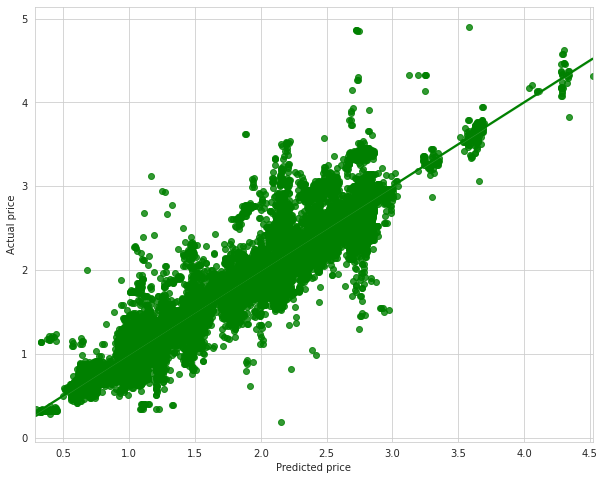

>> RMSE train = 0.2647427759177086
>> RMSE validation = 0.27386329299287027
>> MAE train = 0.17938751062440958
>> MAE validation = 0.18345185969616828
-------------------------------------------------


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
x_features = df_add_encoding.iloc[:,1:]
y_target = df_add_encoding['P_PRICE']

train_model(x_features,y_target)

## Feature Selection

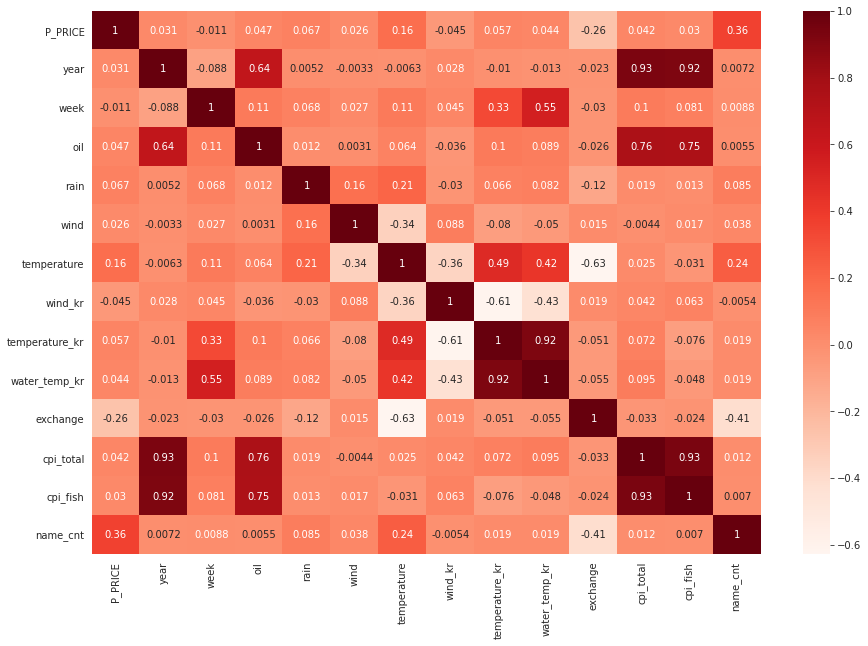

In [ ]:
plt.figure(figsize=(15,10))

sns.heatmap(df_add.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

cpi_fish, cpi_total은 다중공선성 우려, 상관관계 낮음
-> cpi_avg = (cpi_fish + cpi_total)/2 라는 새로운 파생변수 생성

temperature_kr, water_temp_kr은 다중공선성 우려, 상관관계 낮음
-> weather_kr = (temperature_kr+water_temp_kr+wind_kr)/3 라는 새로운 파생변수 생성

rain,wind,temperature 상관관계 낮음
-> weather = (temperature+rain+wind)/3 라는 새로운 파생변수 생성

oil은 타 변수들과 다중공선성 우려, 상관관계 낮음
-> 삭제

### Preprocessing

In [ ]:
df_add_selection = df_add.copy()

df_add_selection['cpi_avg'] = (df_add_selection['cpi_fish']+df_add_selection['cpi_total'])/2
df_add_selection['weather_kr'] = (df_add_selection['temperature_kr']+df_add_selection['water_temp_kr']+df_add_selection['wind_kr'])/3
df_add_selection['weather'] = (df_add_selection['temperature']+df_add_selection['rain']+df_add_selection['wind'])/3

df_add_selection.drop(['cpi_total','cpi_fish','water_temp_kr','temperature_kr','wind_kr','rain','wind','temperature','oil'],axis=1,inplace=True)

df_add_selection = df_add_selection.set_index(['year','week'])

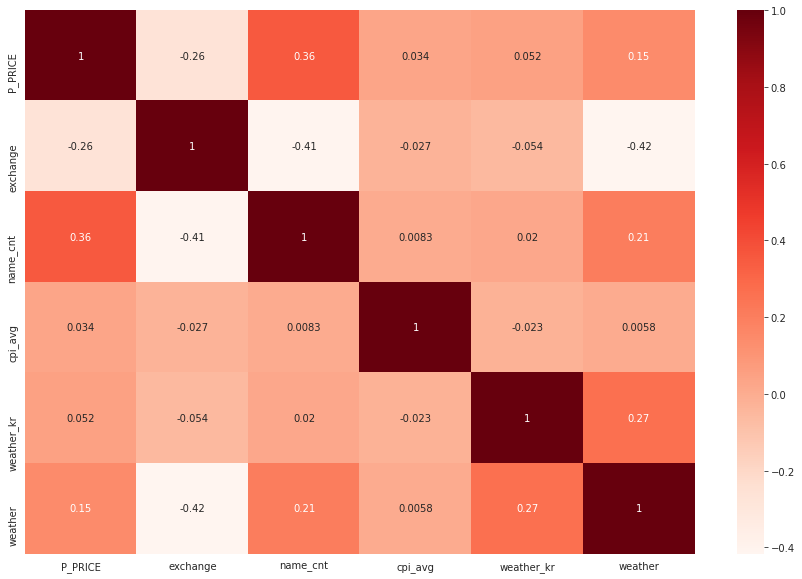

In [ ]:
plt.figure(figsize=(15,10))

sns.heatmap(df_add_selection.corr(), annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
from scipy import stats 

fig = plt.figure(figsize = (15,10))

for i in columns:

  if i == 'weather':
    fig.add_subplot(151) 
    res = stats.probplot(df_add_selection[i], plot=plt) 
    
    fig.add_subplot(152) 
    res = stats.probplot(df_copy[i], plot=plt)
    
    fig.add_subplot(153) 
    res = stats.probplot(df_copy1[i], plot=plt)
    
    fig.add_subplot(154) 
    res = stats.probplot(df_copy2[i], plot=plt)
    
    fig.add_subplot(155) 
    res = stats.probplot(df_copy3[i], plot=plt)

# 파생변수에 로그 변환 필요

<Figure size 1080x720 with 0 Axes>

In [ ]:
# df9_add

df_add_selection['P_PRICE'] = np.log1p(df_add_selection['P_PRICE'])
df_add_selection['weather_kr'] = np.log1p(df_add_selection['weather_kr'])
df_add_selection['cpi_avg'] = np.log1p(df_add_selection['cpi_avg'])
df_add_selection['exchange'] = np.log1p(df_add_selection['exchange'])

df_add_selection


P_PRICE CTRY_1 CTRY_2  ...   cpi_avg weather_kr   weather
year week                          ...                               
2015 53    1.375758     칠레     칠레  ...  1.726760   0.791402  0.620162
     53    1.375758     칠레     칠레  ...  1.726473   0.791402  0.620162
     53    1.014456     칠레     칠레  ...  1.726760   0.791402  0.620162
     53    1.014456     칠레     칠레  ...  1.726473   0.791402  0.620162
     53    0.517042     칠레     칠레  ...  1.726760   0.791402  0.620162
...             ...    ...    ...  ...       ...        ...       ...
2020 1     1.217750     태국     태국  ...  1.745164   0.790238  0.390270
     1     1.118694     태국     태국  ...  1.743547   0.790238  0.390270
     1     1.118694     태국     태국  ...  1.745164   0.790238  0.390270
     1     1.127201     태국     태국  ...  1.743547   0.790238  0.390270
     1     1.127201     태국     태국  ...  1.745164   0.790238  0.390270

[24110 rows x 12 columns]

### Encoding

In [ ]:
# Categorical Features Encoding

df_add_selection_encoding = pd.get_dummies(df_add_selection,columns=['CTRY_1','CTRY_2','CATEGORY_1','CATEGORY_2','P_PURPOSE','P_NAME'])

df_add_selection_encoding

P_PRICE  exchange  name_cnt  ...  P_NAME_흑기흉상어  P_NAME_흑밀복  P_NAME_흰다리새우
year week                                ...                                        
2015 53    1.375758  0.001398        16  ...             0           0             0
     53    1.375758  0.001398        16  ...             0           0             0
     53    1.014456  0.001398       326  ...             0           0             0
     53    1.014456  0.001398       326  ...             0           0             0
     53    0.517042  0.001398      1330  ...             0           0             0
...             ...       ...       ...  ...           ...         ...           ...
2020 1     1.217750  0.032326      1647  ...             0           0             0
     1     1.118694  0.032326      1182  ...             0           0             0
     1     1.118694  0.032326      1182  ...             0           0             0
     1     1.127201  0.032326      1182  ...             0           0             0
     1     1.127201  0.032326      1182  ...             0           0             0

[24110 rows x 272 columns]

## Final Model (Linear Regression)

Model Training Complete!


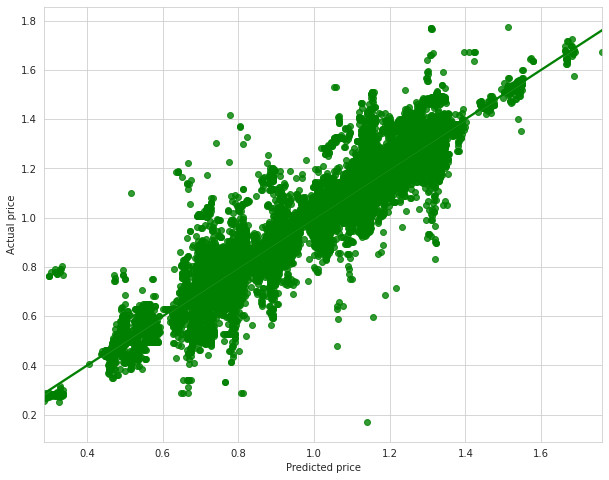

>> RMSE train = 0.09140408093983814
>> RMSE validation = 0.09395165405129055
>> MAE train = 0.06279934782016354
>> MAE validation = 0.06392574547208921
-------------------------------------------------


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
final_model = df_add_selection_encoding

x_features = final_model.iloc[:,1:]
y_target = final_model['P_PRICE']

train_model(x_features,y_target)